In [1]:
import pandas as pd
import numpy as np

In [2]:
data_set = pd.read_csv('../data/TrueFX/EUR-USD/datos_procesados_OHLC_5T_EURUSD-2018-01.csv', parse_dates=True,
                      infer_datetime_format=True,index_col=0)

In [3]:
data_set[:10]

,open,high,low,bid,ask
2018-01-02 00:00:00,1.20094,1.20094,1.20011,1.20015,1.20110
2018-01-02 00:05:00,1.20015,1.20062,1.20011,1.20047,1.20084
2018-01-02 00:10:00,1.20039,1.20098,1.20035,1.20082,1.20126
2018-01-02 00:15:00,1.20080,1.20097,1.20025,1.20035,1.20091
2018-01-02 00:20:00,1.20034,1.20057,1.20031,1.20049,1.20085
2018-01-02 00:25:00,1.20049,1.20054,1.20045,1.20047,1.20085
2018-01-02 00:30:00,1.20048,1.20093,1.20045,1.20079,1.20113
2018-01-02 00:35:00,1.20079,1.20163,1.20073,1.20135,1.20155
2018-01-02 00:40:00,1.20129,1.20145,1.20129,1.20143,1.20158
2018-01-02 00:45:00,1.20143,1.20150,1.20134,1.20149,1.20163


In [4]:
%run ../code/PNLEstimatorWrapper.py
%run ../code/EUtilities.py
EU = EUtilities()

In [5]:
window = 7
X, y_reg, bt = EU.build_dataset(data_set,window=window,bid_col='bid',binary_target=True,PNL=True)
X.shape

(6232, 9)

In [6]:
X.head()

,0,1,2,3,4,5,6,PNL_0,PNL_1
2018-01-02 00:30:00,1.20015,1.20047,1.20082,1.20035,1.20049,1.20047,1.20079,-0.00076,0.00022
2018-01-02 00:35:00,1.20047,1.20082,1.20035,1.20049,1.20047,1.20079,1.20135,-0.00023,-0.00012
2018-01-02 00:40:00,1.20082,1.20035,1.20049,1.20047,1.20079,1.20135,1.20143,-0.00020,-0.00009
2018-01-02 00:45:00,1.20035,1.20049,1.20047,1.20079,1.20135,1.20143,1.20149,-0.00007,-0.00030
2018-01-02 00:50:00,1.20049,1.20047,1.20079,1.20135,1.20143,1.20149,1.20133,-0.00028,-0.00017


In [7]:
X['open'] = data_set.filter(X.index,axis=0).open
X['high'] = data_set.filter(X.index,axis=0).high
X['low'] = data_set.filter(X.index,axis=0).low

In [8]:
X.head()

,0,1,2,3,4,5,6,PNL_0,PNL_1,open,high,low
2018-01-02 00:30:00,1.20015,1.20047,1.20082,1.20035,1.20049,1.20047,1.20079,-0.00076,0.00022,1.20048,1.20093,1.20045
2018-01-02 00:35:00,1.20047,1.20082,1.20035,1.20049,1.20047,1.20079,1.20135,-0.00023,-0.00012,1.20079,1.20163,1.20073
2018-01-02 00:40:00,1.20082,1.20035,1.20049,1.20047,1.20079,1.20135,1.20143,-0.00020,-0.00009,1.20129,1.20145,1.20129
2018-01-02 00:45:00,1.20035,1.20049,1.20047,1.20079,1.20135,1.20143,1.20149,-0.00007,-0.00030,1.20143,1.20150,1.20134
2018-01-02 00:50:00,1.20049,1.20047,1.20079,1.20135,1.20143,1.20149,1.20133,-0.00028,-0.00017,1.20150,1.20150,1.20131


In [9]:
def compute_class_weigth(y):
    u = np.unique(y)
    r = {}
    for i in range(len(u)):
        r[i] = sum(u[0]==y)/sum(u[i]==y)
        
    return r

In [10]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1
wc0 = 0.06 #peso de la clase 0
wc1 = 0.06 #peso de la clase 1
wc2 = 0.44 #peso de la clase 2
wc3 = 0.44 #peso de la clase 3
#para indexar el dataframe por las fechas
dates = np.unique(X.index.date)[n_bdtrain:]
est_GNB = PNLEstimatorWrapper(GaussianNB(priors=(wc0,wc1,wc2,wc3)), PNL_column=['PNL_0','PNL_1'])
result_GNB = EU.step_validation(est_GNB, X, y, EU.v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = EU.redim(result_GNB)

df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2','%total'])
                      , index=dates)

df_GNB = df_GNB.dropna()

print('--------- GaussianNB 5T ----------------')
print('average PNL : ', np.mean(df_GNB.iloc[:,0]))
print('average buy: ', np.mean(df_GNB.iloc[:,1]))
print('average sell: ', np.mean(df_GNB.iloc[:,2]))
print('longest_buy: ', np.max(df_GNB.iloc[:,3]))
print('longest_sell: ', np.max(df_GNB.iloc[:,4]))
print('%correct_1: ', np.mean(df_GNB.iloc[:,5]))
print('%correct_0: ', np.mean(df_GNB.iloc[:,6]))
print('%correct_3: ', np.mean(df_GNB.iloc[:,7]))
print('%correct_2: ', np.mean(df_GNB.iloc[:,8]))
print('% correct total: ', np.mean(df_GNB.iloc[:,9]))
print('-------------------------------------')


wc0 = np.ones(df_GNB.shape[0])*wc0
wc1 = np.ones(df_GNB.shape[0])*wc1
wc2 = np.ones(df_GNB.shape[0])*wc2
wc3 = np.ones(df_GNB.shape[0])*wc3

df_GNB.insert(loc=10,column='wc0',value=wc0)
df_GNB.insert(loc=11,column='wc1',value=wc1)
df_GNB.insert(loc=12,column='wc2',value=wc2)
df_GNB.insert(loc=13,column='wc3',value=wc3)

print(df_GNB)
df_GNB.to_csv('../resultados/TrueFX/EUR-USD/GaussianNB/pnl_5T_weights_GNB_NC4_OHLC_wsize7_2018-01.csv')

--------- GaussianNB 5T ----------------
average PNL :  -0.0017078947368424956
average buy:  124.36842105263158
average sell:  144.3684210526316
longest_buy:  286.0
longest_sell:  288.0
%correct_1:  0.19299347278041012
%correct_0:  0.04878048780487805
%correct_3:  0.27910533060443443
%correct_2:  0.5321291195904199
% correct total:  0.15831293971028082
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-08  0.00000  245.0   34.0           0.0          279.0    0.000000   
2018-01-09 -0.01243  283.0    0.0         283.0            0.0    1.000000   
2018-01-10 -0.00266  261.0   20.0         148.0           73.0    0.747664   
2018-01-11  0.00000  177.0  105.0           0.0          282.0    0.000000   
2018-01-12  0.00000    0.0  280.0           0.0          280.0    0.000000   
2018-01-15  0.00000    0.0  280.0           0.0          280.0    0.000000   
2018-01-16  0.00000    0.0  282.0           0.0          282.

/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:30: RuntimeWarning: invalid value encountered in long_scalars
  percent_1 = sum((pre==1)*(y==1))/sum(y==1) # si sube y gano
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:31: RuntimeWarning: invalid value encountered in long_scalars
  percent_0 = sum((pre==0)*(y==0))/sum(y==0) # si baja y gano
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:33: RuntimeWarning: invalid value encountered in long_scalars
  percent_2 = sum((pre==2)*(y==2))/sum(y==2) # si baja y pierdo
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:32: RuntimeWarning: invalid value encountered in long_scalars
  percent_3 = sum((pre==3)*(y==3))/sum(y==3) # si sube y pierdo


In [11]:
np.mean(df_GNB.dropna().iloc[:,5])

0.19299347278041012

In [12]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree',weights='distance'), PNL_column=['PNL_0','PNL_1'])
result_KNC = EU.step_validation(est_KNC, X, y, EU.v_split(X,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = EU.redim(result_KNC)
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2','%total'])
                      , index=dates)

df_KNC = df_KNC.dropna()

print('--------- GaussianNB 5T ----------------')
print('average PNL : ', np.mean(df_KNC.iloc[:,0]))
print('average buy: ', np.mean(df_KNC.iloc[:,1]))
print('average sell: ', np.mean(df_KNC.iloc[:,2]))
print('longest_buy: ', np.max(df_KNC.iloc[:,3]))
print('longest_sell: ', np.max(df_KNC.iloc[:,4]))
print('%correct_1: ', np.mean(df_KNC.iloc[:,5]))
print('%correct_0: ', np.mean(df_KNC.iloc[:,6]))
print('%correct_3: ', np.mean(df_KNC.iloc[:,7]))
print('%correct_2: ', np.mean(df_KNC.iloc[:,8]))
print('% correct total: ', np.mean(df_KNC.iloc[:,9]))
print('-------------------------------------')

wc0 = 'distance'
wc1 = 'distance'
wc2 = 'distance'
wc3 = 'distance'

df_KNC.insert(loc=10,column='wc0',value=wc0)
df_KNC.insert(loc=11,column='wc1',value=wc1)
df_KNC.insert(loc=12,column='wc2',value=wc2)
df_KNC.insert(loc=13,column='wc3',value=wc3)

print(df_KNC)
df_KNC.to_csv('../resultados/TrueFX/EUR-USD/KNeighborsClassfier/pnl_5T_weights_KNC_NC4_OHLC_wsize7_2018-01.csv')

/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:30: RuntimeWarning: invalid value encountered in long_scalars
  percent_1 = sum((pre==1)*(y==1))/sum(y==1) # si sube y gano
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:31: RuntimeWarning: invalid value encountered in long_scalars
  percent_0 = sum((pre==0)*(y==0))/sum(y==0) # si baja y gano
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:33: RuntimeWarning: invalid value encountered in long_scalars
  percent_2 = sum((pre==2)*(y==2))/sum(y==2) # si baja y pierdo
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:32: RuntimeWarning: invalid value encountered in long_scalars
  percent_3 = sum((pre==3)*(y==3))/sum(y==3) # si sube y pierdo


--------- GaussianNB 5T ----------------
average PNL :  -0.012366842105263912
average buy:  136.3684210526316
average sell:  132.3684210526316
longest_buy:  170.0
longest_sell:  242.0
%correct_1:  0.4767642386066224
%correct_0:  0.5017082406186444
%correct_3:  0.03464912280701754
%correct_2:  0.03588808481650373
% correct total:  0.4173113391763277
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.01172  222.0   57.0         128.0            9.0    0.827273   
2018-01-09 -0.01036  262.0   21.0         170.0            4.0    0.950000   
2018-01-10 -0.01204  122.0  159.0          20.0           46.0    0.327103   
2018-01-11 -0.01317   80.0  202.0           8.0           23.0    0.257812   
2018-01-12 -0.02283   34.0  246.0           5.0          162.0    0.131387   
2018-01-15 -0.00647  224.0   56.0         124.0            8.0    0.786885   
2018-01-16 -0.01473  161.0  121.0          21.0           11.0   

In [13]:
from sklearn.tree import DecisionTreeClassifier


wc0 = 0.2 #peso de la clase 0
wc1 = 0.2 #peso de la clase 1
wc2 = 0.3 #peso de la clase 2
wc3 = 0.3 #peso de la clase 3
est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(class_weight={0:wc0,1:wc1,2:wc2,3:wc3})
                              , PNL_column=['PNL_0','PNL_1'])
result_DTC = EU.step_validation(est_DTC, X, y, EU.v_split(X,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = EU.redim(result_DTC)
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2','%total'])
                      , index=dates)

df_DTC = df_DTC.dropna()

print('--------- GaussianNB 5T ----------------')
print('average PNL : ', np.mean(df_DTC.iloc[:,0]))
print('average buy: ', np.mean(df_DTC.iloc[:,1]))
print('average sell: ', np.mean(df_DTC.iloc[:,2]))
print('longest_buy: ', np.max(df_DTC.iloc[:,3]))
print('longest_sell: ', np.max(df_DTC.iloc[:,4]))
print('%correct_1: ', np.mean(df_DTC.iloc[:,5]))
print('%correct_0: ', np.mean(df_DTC.iloc[:,6]))
print('%correct_3: ', np.mean(df_DTC.iloc[:,7]))
print('%correct_2: ', np.mean(df_DTC.iloc[:,8]))
print('% correct total: ', np.mean(df_DTC.iloc[:,9]))
print('-------------------------------------')


wc0 = np.ones(df_DTC.shape[0])*wc0
wc1 = np.ones(df_DTC.shape[0])*wc1
wc2 = np.ones(df_DTC.shape[0])*wc2
wc3 = np.ones(df_DTC.shape[0])*wc3

df_DTC.insert(loc=10,column='wc0',value=wc0)
df_DTC.insert(loc=11,column='wc1',value=wc1)
df_DTC.insert(loc=12,column='wc2',value=wc2)
df_DTC.insert(loc=13,column='wc3',value=wc3)


print(df_DTC)
df_DTC.to_csv('../resultados/TrueFX/EUR-USD/DecisionTreeClassifier/pnl_5T_weights_DTC_NC4_OHLC_wsize7_2018-01.csv')

/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:30: RuntimeWarning: invalid value encountered in long_scalars
  percent_1 = sum((pre==1)*(y==1))/sum(y==1) # si sube y gano
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:31: RuntimeWarning: invalid value encountered in long_scalars
  percent_0 = sum((pre==0)*(y==0))/sum(y==0) # si baja y gano
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:33: RuntimeWarning: invalid value encountered in long_scalars
  percent_2 = sum((pre==2)*(y==2))/sum(y==2) # si baja y pierdo
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:32: RuntimeWarning: invalid value encountered in long_scalars
  percent_3 = sum((pre==3)*(y==3))/sum(y==3) # si sube y pierdo


--------- GaussianNB 5T ----------------
average PNL :  -0.00958052631578975
average buy:  125.47368421052632
average sell:  143.26315789473685
longest_buy:  214.0
longest_sell:  264.0
%correct_1:  0.4080281818344071
%correct_0:  0.5134034439388756
%correct_3:  0.05787293722156033
%correct_2:  0.05258487242446888
% correct total:  0.39556575951026707
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.00421   69.0  210.0          12.0          165.0    0.145455   
2018-01-09 -0.00973  111.0  172.0          42.0          162.0    0.325000   
2018-01-10 -0.00564  151.0  130.0          19.0           16.0    0.457944   
2018-01-11 -0.00855  124.0  158.0           9.0           15.0    0.359375   
2018-01-12 -0.02390   20.0  260.0           3.0          177.0    0.065693   
2018-01-15 -0.00300  255.0   25.0         214.0            5.0    0.901639   
2018-01-16 -0.00304  184.0   98.0          17.0            7.0 

In [14]:
from sklearn import tree

In [36]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,y)

In [37]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data) 
graph.render('arbol')

'arbol.pdf'

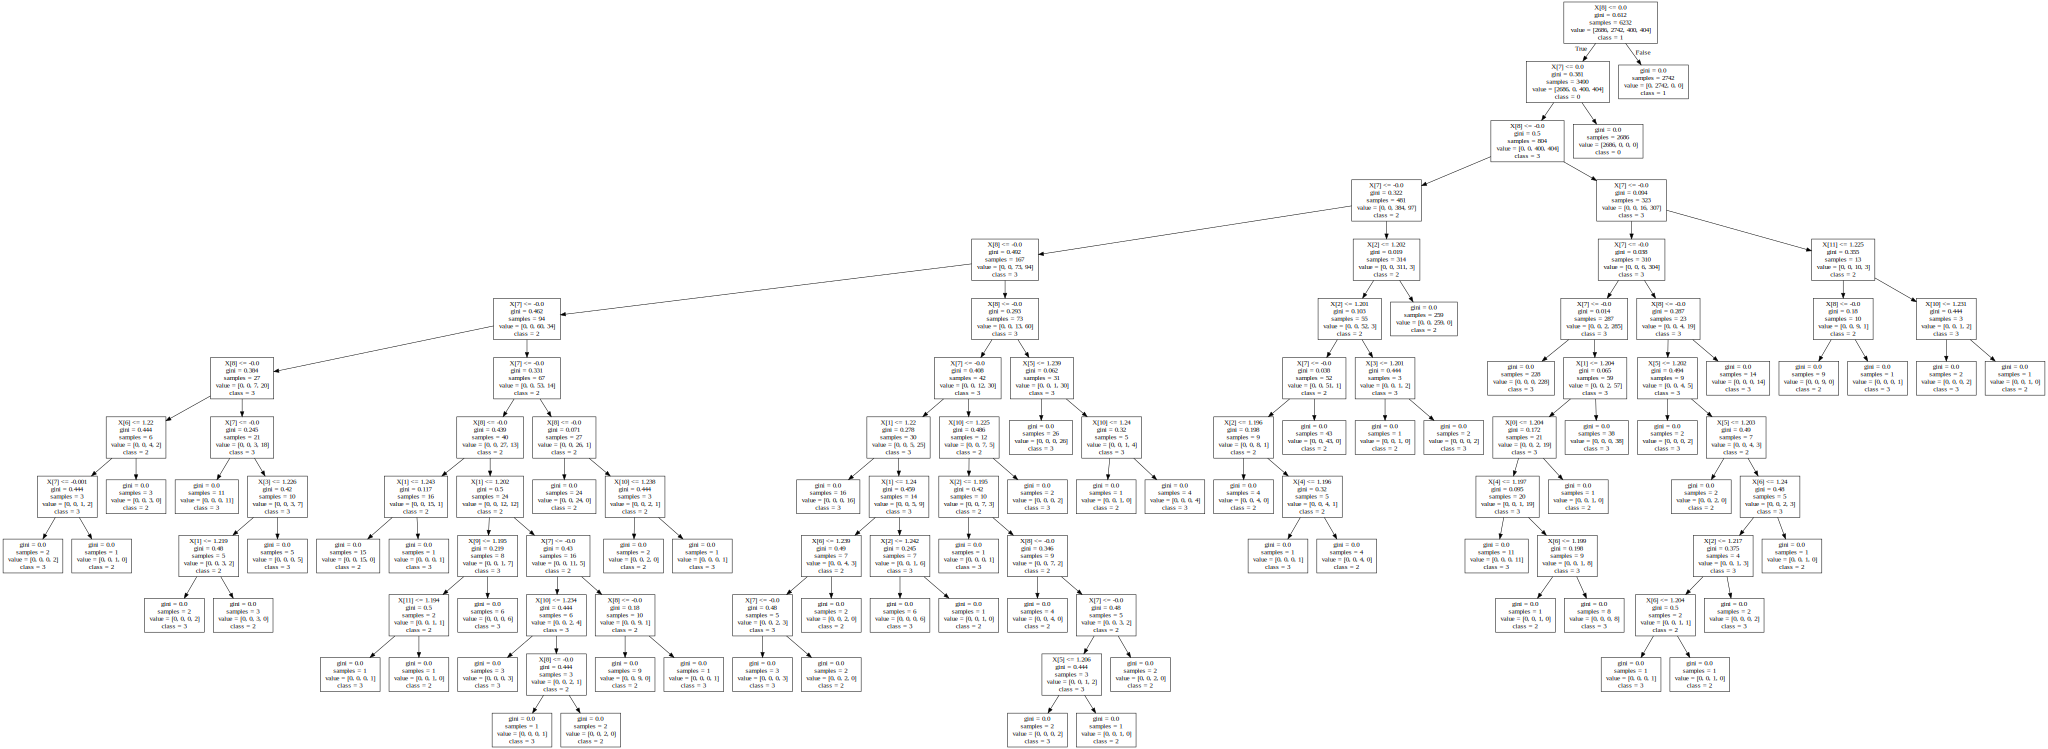

In [41]:
dot_data = tree.export_graphviz(clf,out_file=None, class_names=list(['0','1','2','3']))  
graph = graphviz.Source(dot_data)  
graph 

In [42]:
graph.save('arbol.png')

'arbol.png'

In [51]:
from sklearn.ensemble import RandomForestClassifier

wc0 = 1 #peso de la clase 0
wc1 = 1 #peso de la clase 1
wc2 = 2 #peso de la clase 2
wc3 = 2 #peso de la clase 3

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3,
                                                     class_weight={0:wc0,1:wc1,2:wc2,3:wc3})
                              ,PNL_column=['PNL_1','PNL_0'])
result_RFC = EU.step_validation(est_RFC, X, y, EU.v_split(X,4,1,1))
result_RFC, predict_RFC = EU.redim(result_RFC)
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2','%total'])
                      , index=dates)

df_RFC = df_RFC.dropna()

print('--------- GaussianNB 5T ----------------')
print('average PNL : ', np.mean(df_RFC.iloc[:,0]))
print('average buy: ', np.mean(df_RFC.iloc[:,1]))
print('average sell: ', np.mean(df_RFC.iloc[:,2]))
print('longest_buy: ', np.max(df_RFC.iloc[:,3]))
print('longest_sell: ', np.max(df_RFC.iloc[:,4]))
print('%correct_1: ', np.mean(df_RFC.iloc[:,5]))
print('%correct_0: ', np.mean(df_RFC.iloc[:,6]))
print('%correct_3: ', np.mean(df_RFC.iloc[:,7]))
print('%correct_2: ', np.mean(df_RFC.iloc[:,8]))
print('% correct total: ', np.mean(df_RFC.iloc[:,9]))
print('-------------------------------------')


wc0 = np.ones(df_RFC.shape[0])*wc0
wc1 = np.ones(df_RFC.shape[0])*wc1
wc2 = np.ones(df_RFC.shape[0])*wc2
wc3 = np.ones(df_RFC.shape[0])*wc3

df_RFC.insert(loc=10,column='wc0',value=wc0)
df_RFC.insert(loc=11,column='wc1',value=wc1)
df_RFC.insert(loc=12,column='wc2',value=wc2)
df_RFC.insert(loc=13,column='wc3',value=wc3)

print(df_RFC)
df_RFC.to_csv('../resultados/TrueFX/EUR-USD/RandomForestClassifier/pnl_5T_weights_RFC_NC4_OHLC_wsize7_2018-01.csv')

/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:30: RuntimeWarning: invalid value encountered in long_scalars
  percent_1 = sum((pre==1)*(y==1))/sum(y==1) # si sube y gano
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:31: RuntimeWarning: invalid value encountered in long_scalars
  percent_0 = sum((pre==0)*(y==0))/sum(y==0) # si baja y gano
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:33: RuntimeWarning: invalid value encountered in long_scalars
  percent_2 = sum((pre==2)*(y==2))/sum(y==2) # si baja y pierdo
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:30: RuntimeWarning: invalid value encountered in long_scalars
  percent_1 = sum((pre==1)*(y==1))/sum(y==1) # si sube y gano
/home/edwin/Documentos/Proyecto de grado/code/PNLEstimatorWrapper.py:31: RuntimeWarning: invalid value encountered in long_scalars
  percent_0 = sum((pre==0)*(y==0))/sum(y==0) # si baja y gano
/home/edwin/Documentos/Proyecto d

--------- GaussianNB 5T ----------------
average PNL :  -0.010034736842105861
average buy:  123.21052631578948
average sell:  145.52631578947367
longest_buy:  32.0
longest_sell:  244.0
%correct_1:  0.361049669054805
%correct_0:  0.5575446409831223
%correct_3:  0.0684001670843776
%correct_2:  0.013936781609195403
% correct total:  0.3926646438645203
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.00347  231.0   48.0          14.0          122.0    0.236364   
2018-01-09 -0.01209   96.0  187.0          27.0          162.0    0.266667   
2018-01-10 -0.00532   96.0  185.0          15.0           34.0    0.383178   
2018-01-11 -0.01853   84.0  198.0          10.0           29.0    0.195312   
2018-01-12 -0.02275   20.0  260.0           4.0          175.0    0.065693   
2018-01-15 -0.01291   24.0  256.0          10.0          213.0    0.106557   
2018-01-16 -0.00829  187.0   95.0          17.0            8.0   